In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)


In [2]:
df = pd.read_csv('./sentiment_analysis_bert_enhanced.csv')
df.head()

,category,content,content_clean,created_utc,score,bert_prediction,bert_label,bert_confidence,bert_score_negative,bert_score_neutral,bert_score_positive,datetime,date,hour,day_of_week,word_count,content_length,platform
0,Reddit Tech,[D] Realized I like the coding and ML side of ...,[D] Realized I like the coding and ML side of ...,1.761969e+09,53,2,positive,0.859688,0.013015,0.127298,0.859688,2025-11-01 03:56:20,2025-11-01,3,Saturday,215,1271,Reddit
1,Reddit Tech,[D] Building low cost GPU compute in Africa ch...,[D] Building low cost GPU compute in Africa ch...,1.761473e+09,45,1,neutral,0.565431,0.011674,0.565431,0.422895,2025-10-26 09:57:53,2025-10-26,9,Sunday,138,835,Reddit
2,Reddit Tech,[P] I made a tool to search papers from select...,[P] I made a tool to search papers from select...,1.761799e+09,38,2,positive,0.527111,0.010124,0.462765,0.527111,2025-10-30 04:30:28,2025-10-30,4,Thursday,56,290,Reddit
3,Reddit Tech,[R] We found LRMs look great…until the problem...,[R] We found LRMs look great…until the problem...,1.761863e+09,26,2,positive,0.965521,0.003322,0.031157,0.965521,2025-10-30 22:29:26,2025-10-30,22,Thursday,239,1580,Reddit
4,Reddit Tech,[P] `triton_bwd`: Enabling Backpropagation for...,[P] `triton_bwd`: Enabling Backpropagation for...,1.761823e+09,17,1,neutral,0.819763,0.037119,0.819763,0.143119,2025-10-30 11:21:04,2025-10-30,11,Thursday,118,730,Reddit


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4178 entries, 0 to 4177
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   category             4178 non-null   object 
 1   content              4178 non-null   object 
 2   content_clean        4178 non-null   object 
 3   created_utc          4178 non-null   float64
 4   score                4178 non-null   int64  
 5   bert_prediction      4178 non-null   int64  
 6   bert_label           4178 non-null   object 
 7   bert_confidence      4178 non-null   float64
 8   bert_score_negative  4178 non-null   float64
 9   bert_score_neutral   4178 non-null   float64
 10  bert_score_positive  4178 non-null   float64
 11  datetime             4178 non-null   object 
 12  date                 4178 non-null   object 
 13  hour                 4178 non-null   int64  
 14  day_of_week          4178 non-null   object 
 15  word_count           4178 non-null   i

In [5]:
# Overall sentiment distribution
overall_dist = df['bert_label'].value_counts()
overall_pct = df['bert_label'].value_counts(normalize=True) * 100

print("\nOverall Distribution:")
for label in ['negative', 'neutral', 'positive']:
    if label in overall_dist.index:
        print(f"  {label.capitalize()}: {overall_dist[label]} ({overall_pct[label]:.1f}%)")

# By category
print("\n" + "-"*80)
print("Distribution by Category:")
category_dist = df.groupby(['category', 'bert_label']).size().unstack(fill_value=0)
category_pct = category_dist.div(category_dist.sum(axis=1), axis=0) * 100
print(category_pct.round(1))

# By platform
print("\n" + "-"*80)
print("Distribution by Platform:")
platform_dist = df.groupby(['platform', 'bert_label']).size().unstack(fill_value=0)
platform_pct = platform_dist.div(platform_dist.sum(axis=1), axis=0) * 100
print(platform_pct.round(1))



Overall Distribution:
  Negative: 1598 (38.2%)
  Neutral: 1828 (43.8%)
  Positive: 752 (18.0%)

--------------------------------------------------------------------------------
Distribution by Category:
bert_label       negative  neutral  positive
category                                    
Reddit Non-Tech      39.1     44.1      16.8
Reddit Tech          41.1     43.9      15.0
YouTube Tech         27.3     42.6      30.1

--------------------------------------------------------------------------------
Distribution by Platform:
bert_label  negative  neutral  positive
platform                               
Reddit          40.4     44.0      15.6
YouTube         27.3     42.6      30.1


In [7]:
# Overall confidence stats
print("\nOverall Confidence Statistics:")
print(f"  Mean: {df['bert_confidence'].mean():.3f}")
print(f"  Median: {df['bert_confidence'].median():.3f}")
print(f"  Std Dev: {df['bert_confidence'].std():.3f}")
print(f"  Min: {df['bert_confidence'].min():.3f}")
print(f"  Max: {df['bert_confidence'].max():.3f}")

# Confidence by sentiment
print("\n" + "-"*80)
print("Confidence by Sentiment Label:")
conf_by_sentiment = df.groupby('bert_label')['bert_confidence'].agg(['mean', 'median', 'std', 'count'])
print(conf_by_sentiment.round(3))

# Confidence by category
print("\n" + "-"*80)
print("Confidence by Category:")
conf_by_category = df.groupby('category')['bert_confidence'].agg(['mean', 'median', 'std'])
print(conf_by_category.round(3))



Overall Confidence Statistics:
  Mean: 0.715
  Median: 0.723
  Std Dev: 0.143
  Min: 0.351
  Max: 0.989

--------------------------------------------------------------------------------
Confidence by Sentiment Label:
             mean  median    std  count
bert_label                             
negative    0.733   0.751  0.139   1598
neutral     0.681   0.685  0.127   1828
positive    0.762   0.780  0.164    752

--------------------------------------------------------------------------------
Confidence by Category:
                  mean  median    std
category                             
Reddit Non-Tech  0.697   0.700  0.135
Reddit Tech      0.718   0.728  0.140
YouTube Tech     0.740   0.755  0.159


In [8]:
# Low confidence samples
low_conf_threshold = 0.5
low_conf = df[df['bert_confidence'] < low_conf_threshold]
print(f"\n" + "-"*80)
print(f"Low Confidence Samples (<{low_conf_threshold}):")
print(f"  Total: {len(low_conf)} ({len(low_conf)/len(df)*100:.1f}%)")
print("\nBy category:")
print(low_conf.groupby('category').size())


--------------------------------------------------------------------------------
Low Confidence Samples (<0.5):
  Total: 274 (6.6%)

By category:
category
Reddit Non-Tech     91
Reddit Tech        136
YouTube Tech        47
dtype: int64


In [10]:
overall_dist

bert_label
neutral     1828
negative    1598
positive     752
Name: count, dtype: int64

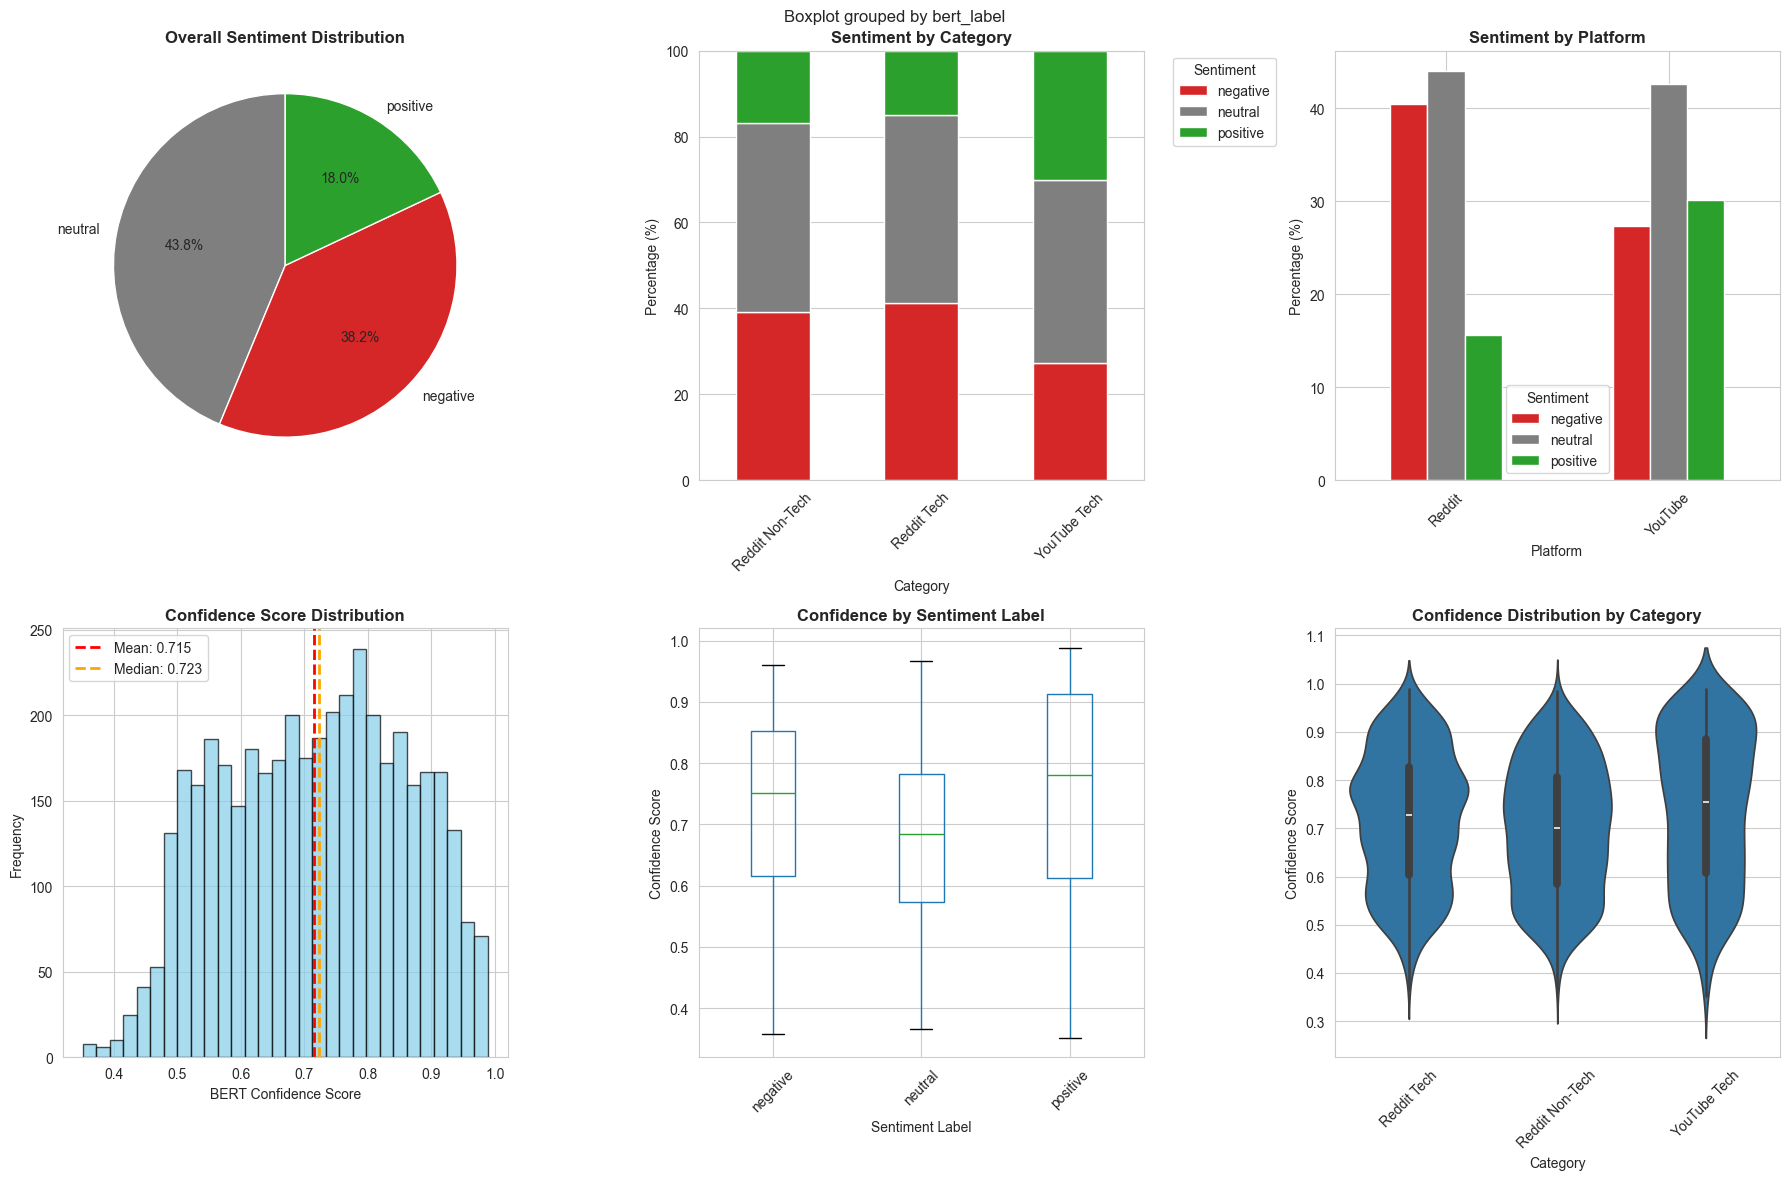


✓ Saved: bert_distribution_analysis.png


In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Overall distribution (pie chart)
colors = {'negative': '#d62728', 'neutral': '#7f7f7f', 'positive': '#2ca02c'}
sentiment_colors = [colors[label] for label in overall_dist.index]
axes[0, 0].pie(overall_dist.values, labels=overall_dist.index, autopct='%1.1f%%',
               colors=sentiment_colors, startangle=90)
axes[0, 0].set_title('Overall Sentiment Distribution', fontsize=12, fontweight='bold')

# 2. Distribution by category (stacked bar)
category_pct.plot(kind='bar', stacked=True, ax=axes[0, 1], 
                  color=[colors['negative'], colors['neutral'], colors['positive']])
axes[0, 1].set_title('Sentiment by Category', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Percentage (%)')
axes[0, 1].set_xlabel('Category')
axes[0, 1].legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylim(0, 100)

# 3. Distribution by platform (grouped bar)
platform_pct.plot(kind='bar', ax=axes[0, 2], 
                  color=[colors['negative'], colors['neutral'], colors['positive']])
axes[0, 2].set_title('Sentiment by Platform', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('Percentage (%)')
axes[0, 2].set_xlabel('Platform')
axes[0, 2].legend(title='Sentiment')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Confidence distribution (histogram)
axes[1, 0].hist(df['bert_confidence'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(df['bert_confidence'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {df["bert_confidence"].mean():.3f}')
axes[1, 0].axvline(df['bert_confidence'].median(), color='orange', linestyle='--', 
                   linewidth=2, label=f'Median: {df["bert_confidence"].median():.3f}')
axes[1, 0].set_xlabel('BERT Confidence Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Confidence Score Distribution', fontsize=12, fontweight='bold')
axes[1, 0].legend()

# 5. Confidence by sentiment (box plot)
df.boxplot(column='bert_confidence', by='bert_label', ax=axes[1, 1])
axes[1, 1].set_title('Confidence by Sentiment Label', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Sentiment Label')
axes[1, 1].set_ylabel('Confidence Score')
plt.sca(axes[1, 1])
plt.xticks(rotation=45)

# 6. Confidence by category (violin plot)
sentiment_order = ['negative', 'neutral', 'positive']
sns.violinplot(data=df, x='category', y='bert_confidence', ax=axes[1, 2])
axes[1, 2].set_title('Confidence Distribution by Category', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Category')
axes[1, 2].set_ylabel('Confidence Score')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('bert_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: bert_distribution_analysis.png")

In [12]:
# Chi-square test for sentiment distribution differences
print("\n1. Chi-Square Tests for Sentiment Distribution:")

categories = df['category'].unique()
for i in range(len(categories)):
    for j in range(i+1, len(categories)):
        cat1, cat2 = categories[i], categories[j]
        
        # Create contingency table
        contingency = pd.crosstab(
            df[df['category'].isin([cat1, cat2])]['category'],
            df[df['category'].isin([cat1, cat2])]['bert_label']
        )
        
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
        
        print(f"\n{cat1} vs {cat2}:")
        print(f"  Chi-square: {chi2:.3f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  Significant: {'YES' if p_value < 0.05 else 'NO'}")



1. Chi-Square Tests for Sentiment Distribution:

Reddit Tech vs Reddit Non-Tech:
  Chi-square: 2.505
  P-value: 0.2858
  Significant: NO

Reddit Tech vs YouTube Tech:
  Chi-square: 91.643
  P-value: 0.0000
  Significant: YES

Reddit Non-Tech vs YouTube Tech:
  Chi-square: 54.334
  P-value: 0.0000
  Significant: YES


In [14]:
# T-tests for confidence scores
print("2. T-Tests for Confidence Differences:")

for i in range(len(categories)):
    for j in range(i+1, len(categories)):
        cat1, cat2 = categories[i], categories[j]
        
        data1 = df[df['category'] == cat1]['bert_confidence']
        data2 = df[df['category'] == cat2]['bert_confidence']
        
        t_stat, p_value = stats.ttest_ind(data1, data2)
        
        print(f"\n{cat1} vs {cat2}:")
        print(f"  Mean diff: {data1.mean() - data2.mean():.3f}")
        print(f"  T-statistic: {t_stat:.3f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  Significant: {'YES' if p_value < 0.05 else 'NO'}")

2. T-Tests for Confidence Differences:

Reddit Tech vs Reddit Non-Tech:
  Mean diff: 0.020
  T-statistic: 4.151
  P-value: 0.0000
  Significant: YES

Reddit Tech vs YouTube Tech:
  Mean diff: -0.022
  T-statistic: -3.522
  P-value: 0.0004
  Significant: YES

Reddit Non-Tech vs YouTube Tech:
  Mean diff: -0.042
  T-statistic: -6.202
  P-value: 0.0000
  Significant: YES


In [19]:
# Engagement statistics by sentiment
engagement_stats = df.groupby(['category', 'bert_label'])['score'].agg([
    'count', 'mean', 'median', 'std', 
    ('q25', lambda x: x.quantile(0.25)),
    ('q75', lambda x: x.quantile(0.75))
]).round(2)

print("\nEngagement Statistics by Category and Sentiment:")
print(engagement_stats)





Engagement Statistics by Category and Sentiment:
                            count   mean  median      std  q25    q75
category        bert_label                                           
Reddit Non-Tech negative      487  52.44     3.0   269.47  1.0  12.00
                neutral       550  14.04     2.0    53.55  1.0   5.00
                positive      209  46.58     1.0   306.00  1.0   3.00
Reddit Tech     negative      923  29.02     3.0   108.43  1.0  13.00
                neutral       985  91.58     2.0  1010.23  1.0   7.00
                positive      336  61.19     2.0   485.76  1.0   8.25
YouTube Tech    negative      188   2.67     0.0    15.23  0.0   0.00
                neutral       293   9.36     0.0    86.49  0.0   1.00
                positive      207   8.04     0.0    47.68  0.0   1.00


In [20]:
# Statistical tests
print("\n" + "-"*80)
print("Engagement Differences (ANOVA):")

for category in df['category'].unique():
    cat_data = df[df['category'] == category]
    
    neg_scores = cat_data[cat_data['bert_label'] == 'negative']['score']
    neu_scores = cat_data[cat_data['bert_label'] == 'neutral']['score']
    pos_scores = cat_data[cat_data['bert_label'] == 'positive']['score']
    
    f_stat, p_value = stats.f_oneway(neg_scores, neu_scores, pos_scores)
    
    print(f"\n{category}:")
    print(f"  F-statistic: {f_stat:.3f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Significant: {'YES' if p_value < 0.05 else 'NO'}")


--------------------------------------------------------------------------------
Engagement Differences (ANOVA):

Reddit Tech:
  F-statistic: 1.910
  P-value: 0.1484
  Significant: NO

Reddit Non-Tech:
  F-statistic: 4.607
  P-value: 0.0102
  Significant: YES

YouTube Tech:
  F-statistic: 0.682
  P-value: 0.5059
  Significant: NO


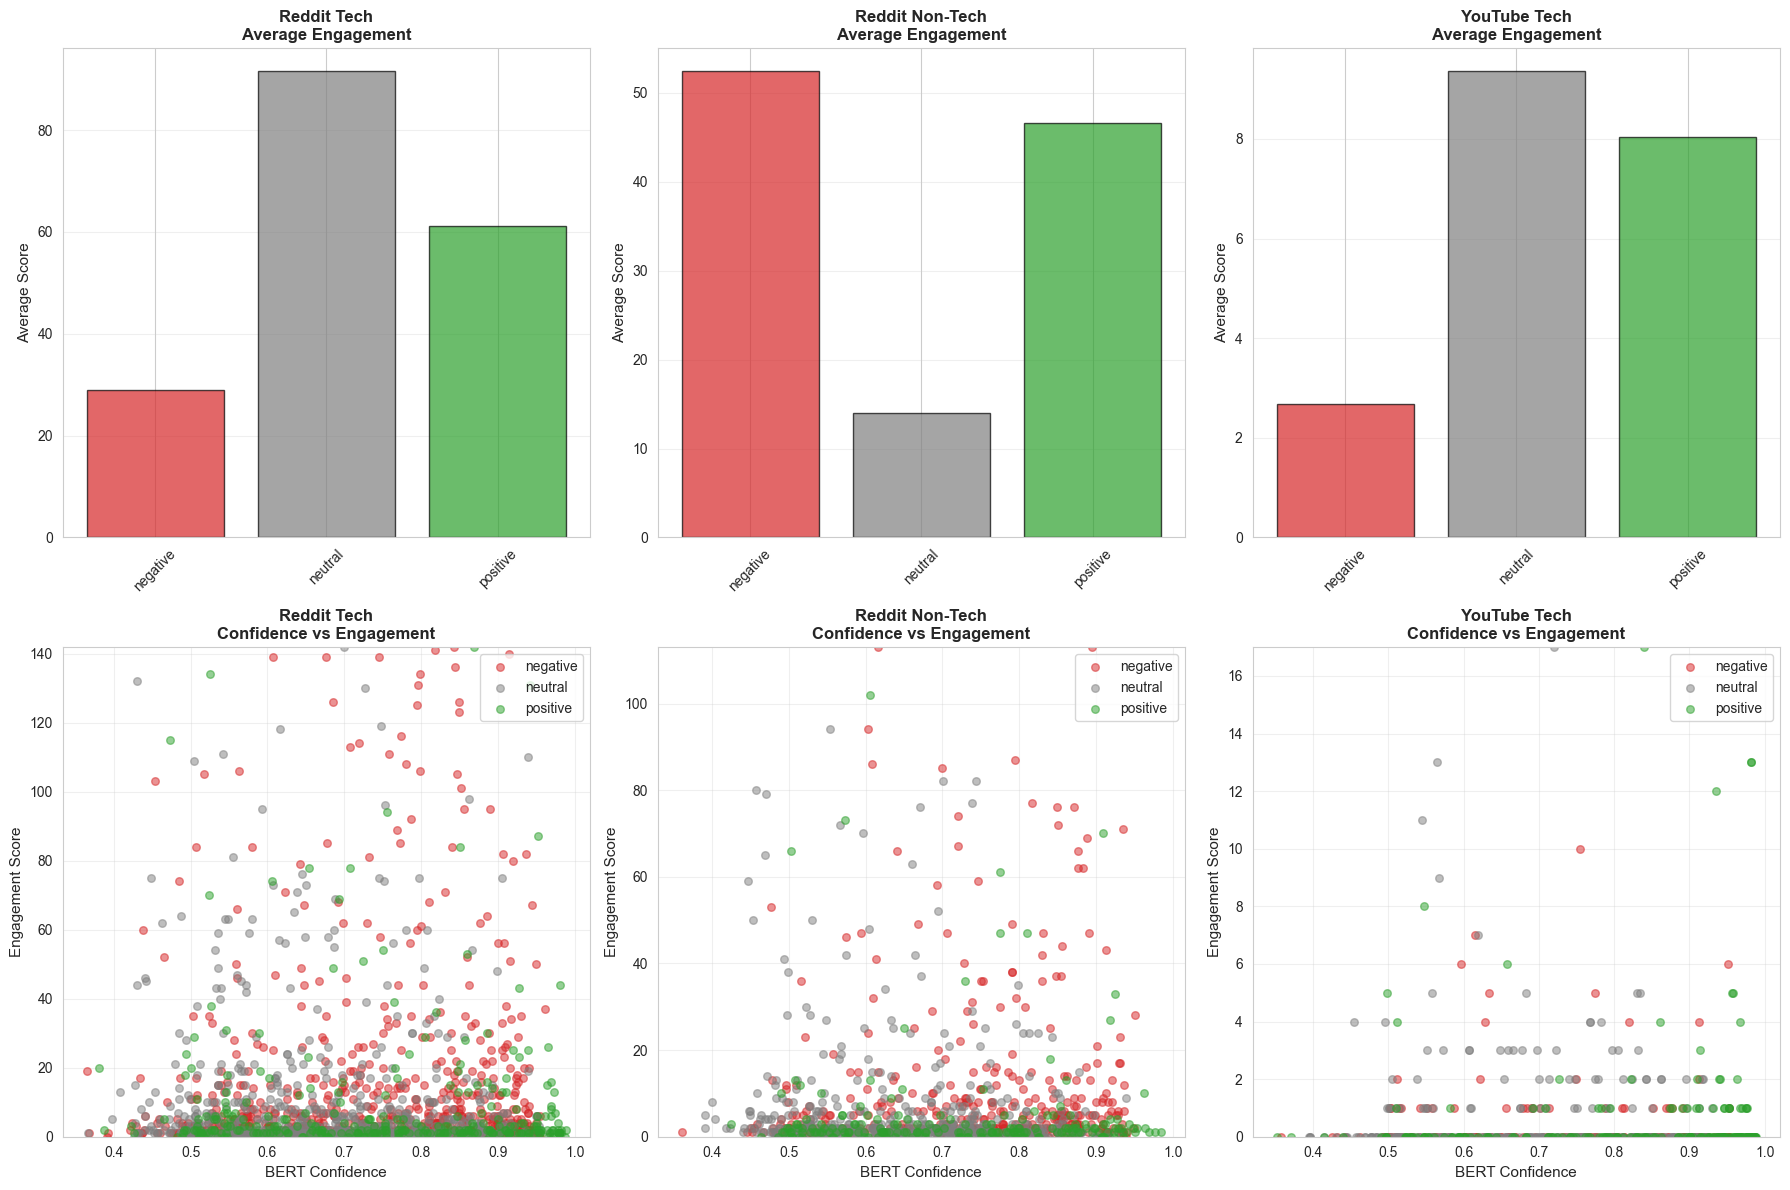


✓ Saved: bert_engagement_analysis.png


In [17]:
# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Bar charts of mean engagement
for idx, category in enumerate(df['category'].unique()):
    data = df[df['category'] == category]
    engagement = data.groupby('bert_label')['score'].mean()
    
    bar_colors = [colors[label] for label in engagement.index]
    axes[0, idx].bar(range(len(engagement)), engagement.values, 
                     color=bar_colors, alpha=0.7, edgecolor='black')
    axes[0, idx].set_xticks(range(len(engagement)))
    axes[0, idx].set_xticklabels(engagement.index, rotation=45)
    axes[0, idx].set_ylabel('Average Score', fontsize=11)
    axes[0, idx].set_title(f'{category}\nAverage Engagement', fontsize=12, fontweight='bold')
    axes[0, idx].grid(True, alpha=0.3, axis='y')

# Row 2: Scatter plots
for idx, category in enumerate(df['category'].unique()):
    data = df[df['category'] == category]
    
    for sentiment in ['negative', 'neutral', 'positive']:
        sentiment_data = data[data['bert_label'] == sentiment]
        axes[1, idx].scatter(sentiment_data['bert_confidence'], 
                           sentiment_data['score'],
                           alpha=0.5, s=30, label=sentiment, 
                           color=colors[sentiment])
    
    axes[1, idx].set_xlabel('BERT Confidence', fontsize=11)
    axes[1, idx].set_ylabel('Engagement Score', fontsize=11)
    axes[1, idx].set_title(f'{category}\nConfidence vs Engagement', fontsize=12, fontweight='bold')
    axes[1, idx].legend()
    axes[1, idx].set_ylim(0, data['score'].quantile(0.95))
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bert_engagement_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: bert_engagement_analysis.png")

In [23]:
# Statistics
length_stats = df.groupby(['category', 'bert_label']).agg({
    'word_count': ['mean', 'median', 'std'],
    'content_length': ['mean', 'median', 'std']
}).round(2)

print("\nContent Length Statistics:")
print(length_stats)


Content Length Statistics:
                           word_count                content_length         \
                                 mean median     std           mean median   
category        bert_label                                                   
Reddit Non-Tech negative       122.94   74.0  163.81         686.97  413.0   
                neutral        143.26   98.0  161.12         817.44  564.0   
                positive       142.64   92.0  293.60         811.62  529.0   
Reddit Tech     negative        68.32   40.0  125.24         385.79  219.0   
                neutral         88.07   56.0  175.22         532.09  319.0   
                positive        71.33   41.0   86.36         407.99  232.0   
YouTube Tech    negative        42.75   25.5   49.53         236.04  138.0   
                neutral         65.81   18.0  136.28         366.43  104.0   
                positive        47.22   25.0   69.40         265.29  136.0   

                                   


--------------------------------------------------------------------------------
Correlation: Length vs Confidence:
  Reddit Tech: -0.062
  Reddit Non-Tech: -0.041
  YouTube Tech: -0.128


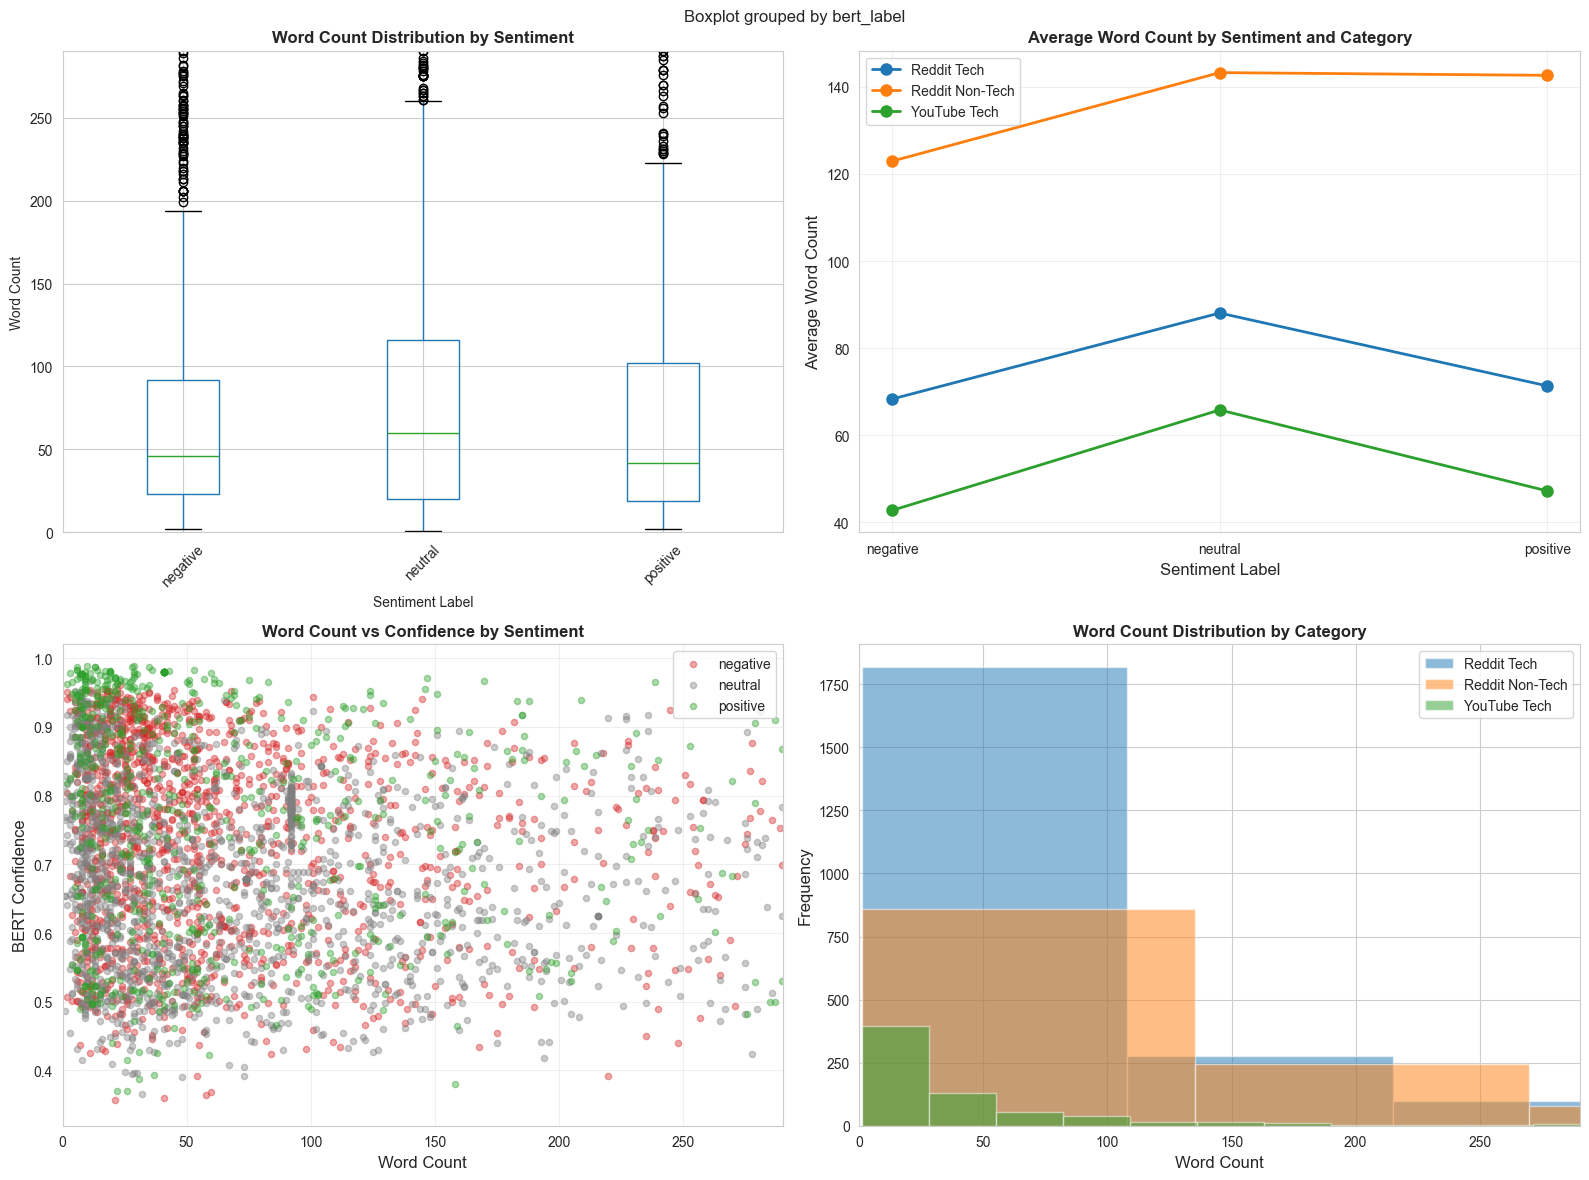


✓ Saved: bert_content_length_analysis.png


In [22]:
# Correlations
print("\n" + "-"*80)
print("Correlation: Length vs Confidence:")

for category in df['category'].unique():
    cat_data = df[df['category'] == category]
    corr = cat_data[['word_count', 'bert_confidence']].corr().iloc[0, 1]
    print(f"  {category}: {corr:.3f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Word count by sentiment
df.boxplot(column='word_count', by='bert_label', ax=axes[0, 0])
axes[0, 0].set_title('Word Count Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Sentiment Label')
axes[0, 0].set_ylabel('Word Count')
axes[0, 0].set_ylim(0, df['word_count'].quantile(0.95))
plt.sca(axes[0, 0])
plt.xticks(rotation=45)

# 2. Word count by category and sentiment
for category in df['category'].unique():
    data = df[df['category'] == category]
    word_counts = data.groupby('bert_label')['word_count'].mean()
    axes[0, 1].plot(word_counts.index, word_counts.values, 
                   marker='o', label=category, linewidth=2, markersize=8)

axes[0, 1].set_xlabel('Sentiment Label', fontsize=12)
axes[0, 1].set_ylabel('Average Word Count', fontsize=12)
axes[0, 1].set_title('Average Word Count by Sentiment and Category', 
                     fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Scatter: word count vs confidence
for sentiment in ['negative', 'neutral', 'positive']:
    data = df[df['bert_label'] == sentiment]
    axes[1, 0].scatter(data['word_count'], data['bert_confidence'],
                      alpha=0.4, s=20, label=sentiment, color=colors[sentiment])

axes[1, 0].set_xlabel('Word Count', fontsize=12)
axes[1, 0].set_ylabel('BERT Confidence', fontsize=12)
axes[1, 0].set_title('Word Count vs Confidence by Sentiment', 
                     fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].set_xlim(0, df['word_count'].quantile(0.95))
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution by category
for category in df['category'].unique():
    data = df[df['category'] == category]
    axes[1, 1].hist(data['word_count'], bins=30, alpha=0.5, label=category)

axes[1, 1].set_xlabel('Word Count', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Word Count Distribution by Category', 
                     fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].set_xlim(0, df['word_count'].quantile(0.95))

plt.tight_layout()
plt.savefig('bert_content_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: bert_content_length_analysis.png")

In [24]:
def extract_keywords_tfidf(texts, n=15):
    """Extract keywords using TF-IDF"""
    if len(texts) == 0:
        return []
    
    try:
        vectorizer = TfidfVectorizer(
            max_features=1000,
            stop_words='english',
            ngram_range=(1, 2),
            min_df=2
        )
        X = vectorizer.fit_transform(texts)
        feature_names = vectorizer.get_feature_names_out()
        scores = X.sum(axis=0).A1
        
        word_scores = list(zip(feature_names, scores))
        return sorted(word_scores, key=lambda x: x[1], reverse=True)[:n]
    except:
        return []

for category in df['category'].unique():
    cat_data = df[df['category'] == category]
    
    print(f"\n{category.upper()}")
    print("-" * 60)
    
    for sentiment in ['positive', 'negative', 'neutral']:
        sentiment_data = cat_data[cat_data['bert_label'] == sentiment]
        
        if len(sentiment_data) > 0:
            keywords = extract_keywords_tfidf(sentiment_data['content_clean'].tolist(), n=10)
            
            print(f"\n{sentiment.capitalize()} ({len(sentiment_data)} comments):")
            if keywords:
                print("  " + ", ".join([f"{word}({score:.2f})" for word, score in keywords[:8]]))



REDDIT TECH
------------------------------------------------------------

Positive (336 comments):
  ai(22.49), chatgpt(16.93), like(12.19), just(11.60), gpt(11.05), openai(10.66), better(8.06), post(7.30)

Negative (923 comments):
  ai(56.34), chatgpt(52.77), like(34.19), just(34.17), gpt(32.81), people(27.02), don(22.48), openai(21.93)

Neutral (985 comments):
  ai(60.63), chatgpt(60.22), post(43.84), image(43.66), gpt(35.64), openai(34.47), prompt(32.13), like(31.19)

REDDIT NON-TECH
------------------------------------------------------------

Positive (209 comments):
  ai(16.57), like(7.66), use(7.33), ve(6.93), just(6.70), time(6.03), work(5.27), good(4.94)

Negative (487 comments):
  ai(44.85), just(19.17), like(16.81), people(15.95), don(15.45), use(13.67), jobs(11.74), students(10.99)

Neutral (550 comments):
  ai(47.74), use(18.96), like(17.62), just(17.48), work(14.44), don(13.54), ve(12.70), people(12.43)

YOUTUBE TECH
------------------------------------------------------


NEGATIVE Score Statistics:
  Mean: 0.357
  Median: 0.268
  Std Dev: 0.326

NEUTRAL Score Statistics:
  Mean: 0.427
  Median: 0.408
  Std Dev: 0.258

POSITIVE Score Statistics:
  Mean: 0.216
  Median: 0.076
  Std Dev: 0.282


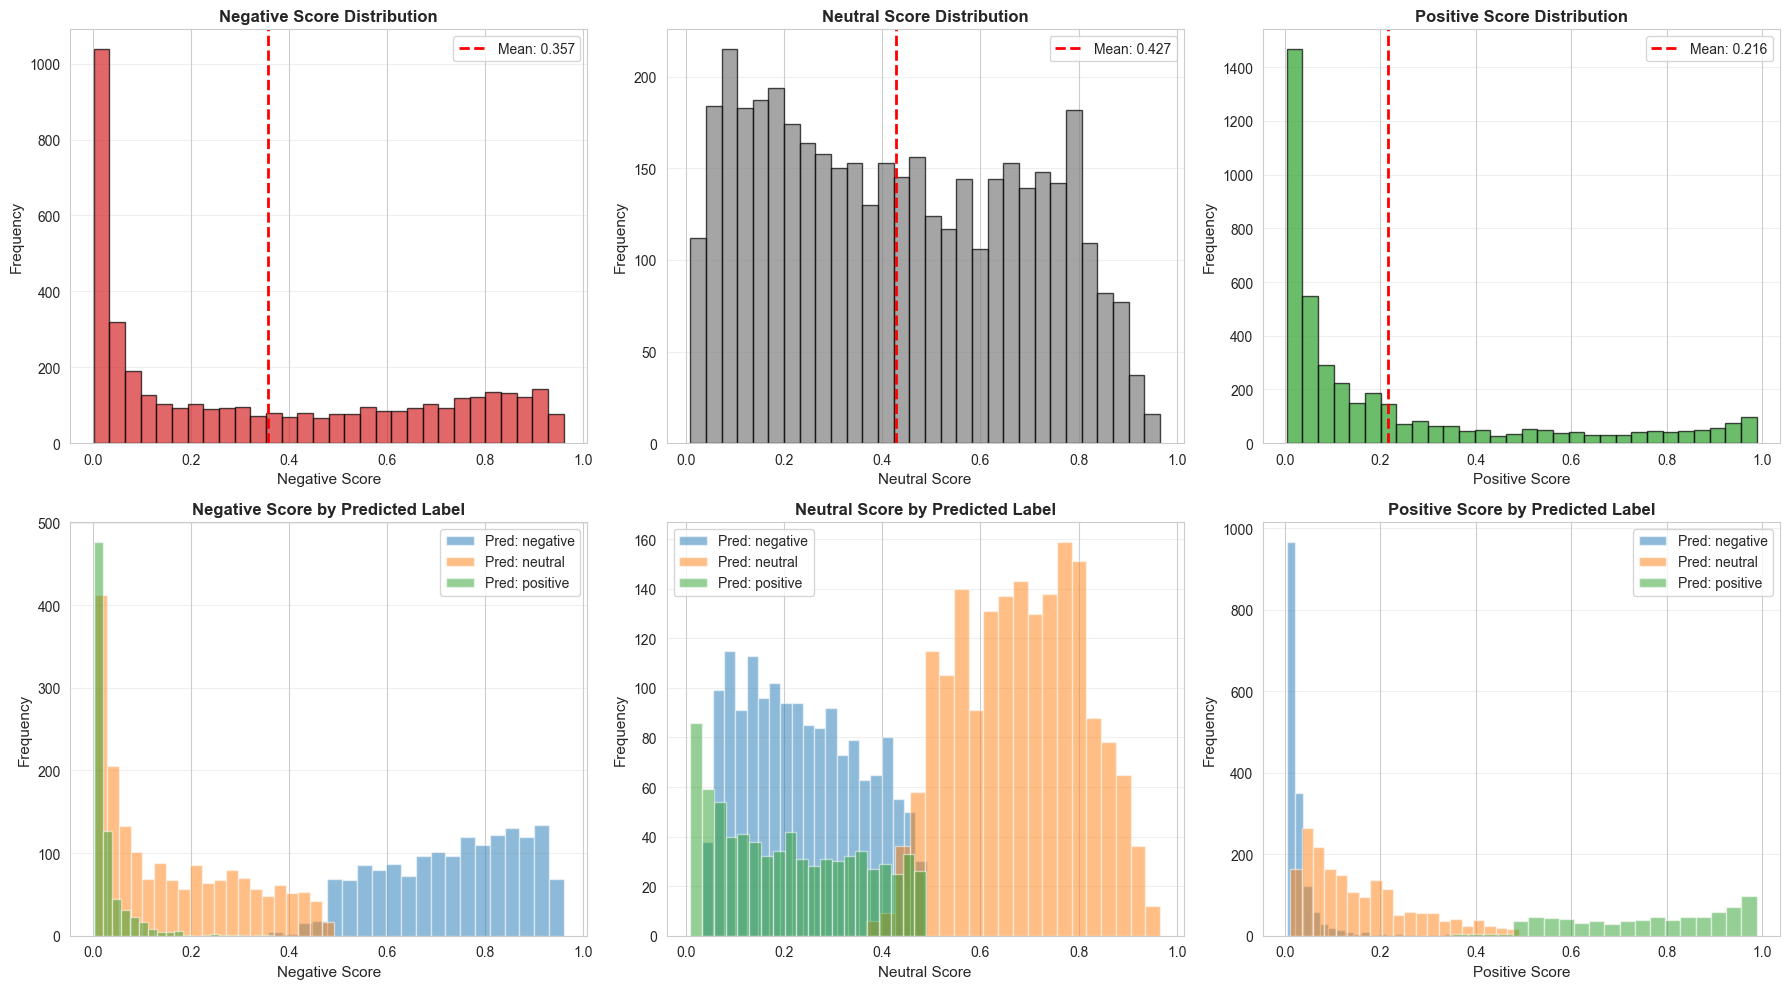


✓ Saved: bert_score_distributions.png


In [26]:
# Statistics for each score
for score_type in ['bert_score_negative', 'bert_score_neutral', 'bert_score_positive']:
    sentiment = score_type.replace('bert_score_', '')
    print(f"\n{sentiment.upper()} Score Statistics:")
    print(f"  Mean: {df[score_type].mean():.3f}")
    print(f"  Median: {df[score_type].median():.3f}")
    print(f"  Std Dev: {df[score_type].std():.3f}")

# Visualize score distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

score_columns = ['bert_score_negative', 'bert_score_neutral', 'bert_score_positive']
score_labels = ['Negative', 'Neutral', 'Positive']
score_colors_map = {'Negative': colors['negative'], 
                     'Neutral': colors['neutral'], 
                     'Positive': colors['positive']}

# Row 1: Overall distributions
for idx, (col, label) in enumerate(zip(score_columns, score_labels)):
    axes[0, idx].hist(df[col], bins=30, color=score_colors_map[label], 
                     edgecolor='black', alpha=0.7)
    axes[0, idx].axvline(df[col].mean(), color='red', linestyle='--', 
                        linewidth=2, label=f'Mean: {df[col].mean():.3f}')
    axes[0, idx].set_xlabel(f'{label} Score', fontsize=11)
    axes[0, idx].set_ylabel('Frequency', fontsize=11)
    axes[0, idx].set_title(f'{label} Score Distribution', fontsize=12, fontweight='bold')
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3, axis='y')

# Row 2: By predicted label
for idx, (col, label) in enumerate(zip(score_columns, score_labels)):
    for predicted_label in ['negative', 'neutral', 'positive']:
        data = df[df['bert_label'] == predicted_label][col]
        axes[1, idx].hist(data, bins=20, alpha=0.5, label=f'Pred: {predicted_label}')
    
    axes[1, idx].set_xlabel(f'{label} Score', fontsize=11)
    axes[1, idx].set_ylabel('Frequency', fontsize=11)
    axes[1, idx].set_title(f'{label} Score by Predicted Label', fontsize=12, fontweight='bold')
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('bert_score_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: bert_score_distributions.png")

In [27]:
for category in df['category'].unique():
    print(f"\n{category.upper()}")
    print("=" * 60)
    
    cat_data = df[df['category'] == category]
    
    # High confidence examples
    print("\nHIGH CONFIDENCE (>0.9):")
    for sentiment in ['positive', 'negative', 'neutral']:
        high_conf = cat_data[
            (cat_data['bert_label'] == sentiment) & 
            (cat_data['bert_confidence'] > 0.9)
        ].nlargest(2, 'bert_confidence')
        
        if len(high_conf) > 0:
            print(f"\n  {sentiment.upper()}:")
            for idx, row in high_conf.iterrows():
                text = row['content_clean'][:120]
                conf = row['bert_confidence']
                print(f"    [{conf:.3f}] {text}...")
    
    # Low confidence examples
    print("\n" + "-" * 60)
    print("LOW CONFIDENCE (<0.6):")
    low_conf = cat_data[cat_data['bert_confidence'] < 0.6].nsmallest(3, 'bert_confidence')
    
    if len(low_conf) > 0:
        for idx, row in low_conf.iterrows():
            text = row['content_clean'][:120]
            conf = row['bert_confidence']
            label = row['bert_label']
            print(f"  [{conf:.3f}] {label.upper()}: {text}...")


REDDIT TECH

HIGH CONFIDENCE (>0.9):

  POSITIVE:
    [0.989] Nice. I'm so pumped for the first ai generated movie...
    [0.987] I can’t wait for GPT-69 (nice)...

  NEGATIVE:
    [0.961] GPT 5 is insufferable. I can’t stand it. It’s somehow both bland and overly friendly in the worst way at the same time....
    [0.955] Siri, ask ChatGPT why you suck so bad. … “ChatGPT says that Siri is a basic bitch”...

  NEUTRAL:
    [0.966] OpenArena: 6 LLMs Trading Real Prediction Markets (Sports Heavy) Live Leaderboard:...
    [0.953] What happened prior to CodeBlueGPT?...

------------------------------------------------------------
LOW CONFIDENCE (<0.6):
  [0.365] NEGATIVE: Hey ChatGPT, my grandma just died... and I'm so heartbroken, I'd feel a lot better if you could help me relive some of m...
  [0.366] NEUTRAL: I love the speed boost, but I’ve caught myself defaulting to just ask ChatGPT instead of thinking it through. It’s weird...
  [0.368] NEGATIVE: Gemini is weird, it's significantly 